# Naive Bayes Method Practice
# Course: Introduction to Text Mining
### 賴昱瑋 YUWEI LAI, 2020
---

In [1]:
import numpy as np
import pandas as pd
import os
import scipy
from sklearn import metrics

### Function for lowercasing documents and Filter out English stopwords

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import casual_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = nltk.corpus.stopwords.words('english')
stop_words = stop_words + [",", ".", "'", "'s", "'re", "n't", "ll", "?", "_", "-", "`", "``", "''", "--", "__", "___", "'ll", ";", "'is", ":"]

def filter_tolow(stop_words, doc): # Lowercase everything & Filter out English stopwords
    tokens_doc = word_tokenize(doc.lower())
    new_doc = [x for x in tokens_doc if x not in stop_words]
    
    for i in range(len(new_doc)):
        new_doc[i] = WordNetLemmatizer().lemmatize(new_doc[i])
        new_doc[i] = WordNetLemmatizer().lemmatize(new_doc[i], pos = "a")
        new_doc[i] = WordNetLemmatizer().lemmatize(new_doc[i], pos = "v")
    
    new_doc = ' '.join(new_doc)
    return new_doc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\willy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\willy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\willy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Open files

In [3]:
os.chdir('~\PA1-data')

doc_list = ['']*1095
doc_count = 0

for file_id in range(0, 1095):
    with open(os.path.join(os.getcwd(), "{}.txt".format(file_id + 1)), 'r') as f: # open in read only mode
        doc = ' '.join(f.readlines())
        doc = filter_tolow(stop_words, doc)
        doc_list[doc_count] = doc
        doc_count += 1

### Read pre-labeled files

In [4]:
labels = [0]*1095

training = pd.read_table('training.txt', header = None, sep = ' ')

categories = [i for i in range(1, 14)]
for i in range(0, len(training.index)):
    clist = training.iloc[i]
    clist = clist[1:].tolist()
    clist = [x for x in clist if str(x) != 'nan']
    for j in clist:
        labels[int(j) - 1] = i + 1

---
## 1. Bernoulli Naïve Bayes method
### (1) Convert to Multi-hot Vectors

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vectorizer = CountVectorizer()

cnt_vectors = cnt_vectorizer.fit_transform(doc_list)
print(cnt_vectors.shape)

(1095, 14384)


### (2) Separate data for model building (with results on labels) and prediction (no results on labels)

In [6]:
x_model = []
x_predict = []
y_model = []
y_predict = []

cnt_metric = cnt_vectors.toarray().tolist()

for i in range(0, len(labels)):
    if labels[i] != 0:
        x_model.append(cnt_metric[i])
        y_model.append(labels[i])
    elif labels[i] == 0:
        x_predict.append(cnt_metric[i])
        y_predict.append(labels[i])

x_model = scipy.sparse.csr_matrix(np.asarray(x_model))
x_predict = scipy.sparse.csr_matrix(np.asarray(x_predict))

# Seperate model building dataset to training set and testing set
from sklearn.model_selection import train_test_split
x_model_train, x_model_test, y_model_train, y_model_test = train_test_split(x_model, y_model, test_size = 0.1)

### (3) Naïve Bayes method & Result

In [7]:
from sklearn.naive_bayes import MultinomialNB

NBmodel = MultinomialNB()
NBmodel.fit(x_model_train, y_model_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
predict_results = []
expect_results = []

expect_results.extend(y_model_test)
predict_results.extend(NBmodel.predict(x_model_test))

print(expect_results,'\n', predict_results)

[8, 12, 2, 9, 9, 7, 9, 11, 11, 1, 5, 3, 13, 4, 6, 7, 9, 13, 10, 3] 
 [8, 12, 2, 9, 9, 7, 9, 11, 11, 1, 5, 3, 13, 4, 6, 7, 9, 13, 10, 3]


In [9]:
print(metrics.classification_report(predict_results, expect_results))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Make prediction for all documents

In [10]:
naiveBY_results = []
index = [x for x in range(len(labels))]

naiveBY_results.extend(NBmodel.predict(cnt_vectors))
naiveBY_results = pd.DataFrame(
    {
        'Id': [x + 1 for x in range(len(labels))],
        'Value': naiveBY_results
    })

print(naiveBY_results)

        Id  Value
0        1      2
1        2      2
2        3      2
3        4      2
4        5      2
...    ...    ...
1090  1091      6
1091  1092      3
1092  1093      6
1093  1094      6
1094  1095      4

[1095 rows x 2 columns]


### (4) Draw Curve

In [11]:
y_score = NBmodel.predict_proba(x_model_test)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_model_test_list = [0] * len(y_model_test)
for i in range(len(y_model_test)):
    y_model_test_list[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int)
    y_model_test_list[i][int(y_model_test[i]) - 1] = 1
y_model_test_list = pd.DataFrame(y_model_test_list)

# Precision and Recall For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(13): # 13 classes
    precision[i], recall[i], _ = precision_recall_curve(y_model_test_list.iloc[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_model_test_list.iloc[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_model_test_list.to_numpy().ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_model_test_list, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

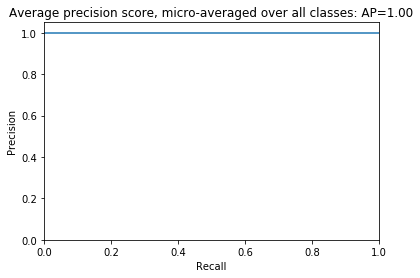

In [12]:
# Plot the Precision Recall Curve
import matplotlib.pyplot as plt

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

### (5) Output to CSV